<a href="https://colab.research.google.com/github/peeush-the-developer/LGMVIP-DataScience/blob/main/Handwritten-Math-Equation-Solver/1_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Math Equation solver

We can approach this problem statement in the following steps:

1. We are given a dataset of images for different Math symbols using which we can train our Image classification model to classify images as math symbols.
2. Next, we take an image with complete math equation and try to segregate each symbol into smaller images
3. Pass these smaller images to find the actual symbol and then solve the equation as a normal math equation.

Easy huh!

Let's get started!

In [20]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Train a CNN model to classify given image into Math symbol

1. Download the dataset with math symbol images
2. Train a CNN model to classify them into Math symbol
3. Evaluate the model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

%matplotlib inline

plt.ion()   # interactive mode


In [22]:
input_folder = '/gdrive/My Drive/Projects/Handwritten-Math-Equation-Solver/input_images'

In [39]:
def loaders(dataset_path, validation_size = 0.2, batch_size = 4, verbose=False):
    '''
    Input: dataset_path = Path to the dataset directory
    Output: Loaders for train and validation images
    '''
    # Build transformations to be applied on the images
    transformations = transforms.Compose([
        # transforms.Grayscale(),
        # transforms.GaussianBlur(3),
        # transforms.Resize((28,28)),
        transforms.Resize((224, 224)), # VGG16 model requirement
        transforms.ToTensor()])
    # Build dataset object for all the images in the specified path
    dataset = torchvision.datasets.ImageFolder(dataset_path, transformations)
    # Build labels dict {index: class_name}
    labels_dict = {dataset.class_to_idx[c]:c for c in dataset.classes}
    
    n_items = len(dataset)
    valid_set_size = int(n_items*validation_size)
    train_set_size = n_items - valid_set_size
    train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])

    if verbose:
        print(len(train_set))
        print(len(valid_set))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

    dataloaders = {'train': train_loader, 'val': valid_loader}
    dataset_sizes = {'train': len(train_set), 'val':len(valid_set)}
    
    return dataloaders, dataset_sizes, labels_dict

In [40]:
def imshow(loader, labels_dict):
    images, labels = next(iter(loader))
    images = torchvision.utils.make_grid(images)

    plt.imshow(images.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(','.join([labels_dict[i.item()] for i in labels]))
    plt.show()

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [42]:
dataloaders, dataset_sizes, labels_dict = loaders(input_folder, batch_size=32)

In [43]:
print(labels_dict)

{0: '+', 1: '-', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: '=', 13: 'div', 14: 'times'}


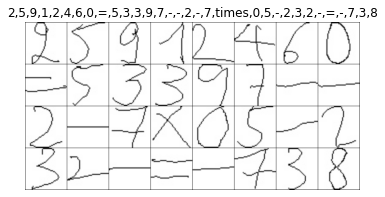

In [44]:
imshow(dataloaders['train'], labels_dict)

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs.shape)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(labels_dict[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [52]:
len(labels_dict)

15

In [53]:
model_ft = models.vgg16(pretrained=True)

num_ftrs = model_ft.classifier[6].in_features
layers = list(model_ft.classifier.children())[:-1]
layers.extend([nn.Linear(num_ftrs, len(labels_dict))])
model_ft.classifier = nn.Sequential(*layers)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(labels_dict))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
visualize_model(model_ft)